In [117]:
import pandas as pd
import json
import os
root_file = './CLEAN_DB_VERSIONS/CLEAN_DB_FOR_GNN/'
train = pd.read_csv(os.path.join(root_file, 'train.txt'), header=None, names=['h', 'r', 't'])
test = pd.read_csv(os.path.join(root_file, 'test.txt'), header=None, names=['h', 'r', 't'])
map_ = pd.read_csv(os.path.join(root_file, 'DB_Bert_Emb_INT__MAPPING.csv'))
db2index = dict(zip(map_.DB_ID, map_.INDEX))
index2db = dict(zip(map_.INDEX, map_.DB_ID))
emb_ = pd.read_csv(os.path.join(root_file, 'DB_Bert_Emb_INT.csv'))
mapping = {}
for i, row in emb_.iterrows():
    mapping[row['DB_ID']] = row[:-1].values
db_ids = db2index.keys()
assert len(set(index2db.keys()).difference(train['h'].unique().tolist()+train['t'].unique().tolist()+test['h'].unique().tolist()+test['t'].unique().tolist())) == 0

In [118]:
print("UNIQUE NODES: %d" % (len(db2index)))

UNIQUE NODES: 3679


In [119]:
import tqdm
import random
import faiss                   # make faiss available
import numpy as np
from faiss import pairwise_distances


X_all = []
for _, row in emb_.iterrows():
    X_all.append(row.values[:-1].reshape(-1))
X_all = np.ascontiguousarray(np.array(X_all), dtype=np.float32)
dim_size = row[:-1].values.size
index = faiss.IndexFlatL2(dim_size)   # build the index
index.add(X_all)
distances = pairwise_distances(X_all, X_all)

In [120]:
pairs = train['h'].astype(str) + '_' + train['t'].astype(str)
x_train_pairs = list(set(pairs))
print(len(pairs), len(x_train_pairs))

pairs = test['h'].astype(str) + '_' + test['t'].astype(str)
x_test_pairs = list(set(pairs))
print(len(pairs), len(x_test_pairs))

290722 290722
1004167 1004167


In [121]:
import numpy as np
def get_sparsity(A):
    return 1.0 - ( np.count_nonzero(A) / float(A.size) )

# Adj matrix (train)

adj_train = np.zeros((len(db_ids), len(db_ids)), dtype=np.int8)
for item in x_train_pairs:
    splits = item.split("_")
    try:
        adj_train[int(splits[0]), int(splits[1])] = 1
    except KeyError:
        continue
        
        
print("Sparsity Train: %0.2f%%"%(100*get_sparsity(adj_train)))

adj_test = np.zeros((len(db_ids), len(db_ids)), dtype=np.int8)
for item in x_test_pairs:
    splits = item.split("_")
    try:
        adj_test[int(splits[0]), int(splits[1])] = 1
    except KeyError:
        continue

print("Sparsity Test: %0.2f%%"%(100*get_sparsity(adj_test)))

adj_all = np.zeros_like(adj_train, dtype=np.int8)
adj_all = adj_train + adj_test
adj_all = np.clip(adj_all, 0, 1)
print("Sparsity Total: %0.2f%%"%(100*get_sparsity(adj_all)))

Sparsity Train: 97.85%
Sparsity Test: 92.58%
Sparsity Total: 90.43%


In [122]:
labels = distances*(adj_train + adj_test)
labels[labels>0] = 1
labels = labels.astype(np.int8, copy=False)
print("Sparsity of labels: %0.2f %%" % (100*get_sparsity(labels)))

Sparsity of labels: 90.43 %


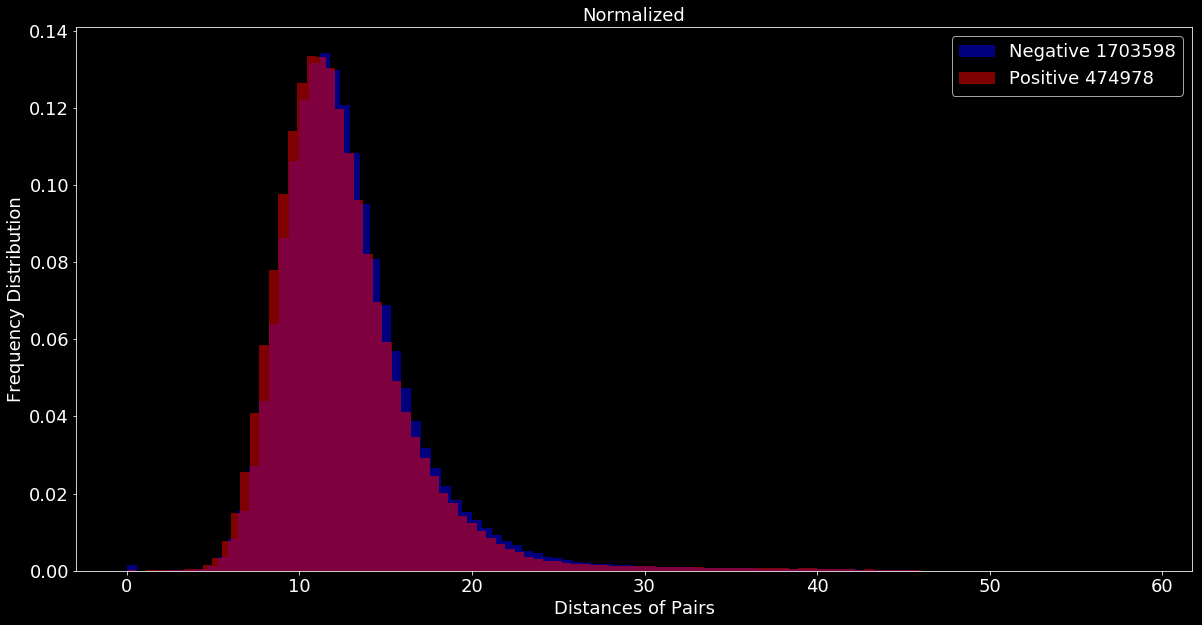

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.figure(figsize=(20,10))
zero_index = np.argwhere(labels.ravel() == 0)
plt.hist(distances.ravel()[zero_index.ravel()], bins=100, density=True, color='Blue', alpha=0.5, label='Negative %d' % len(zero_index))

nonzero_index = np.argwhere(labels.ravel() > 0)
plt.hist(distances.ravel()[nonzero_index.ravel()], bins=100, density=True, color='Red', alpha=0.5, label='Positive %d' % len(nonzero_index))

plt.xlabel('Distances of Pairs', fontsize=18)
plt.ylabel('Frequency Distribution', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Normalized', fontsize=18)
plt.legend(fontsize=18)

In [123]:
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler
probas = 1 -MinMaxScaler().fit_transform(distances.reshape(-1,1)).ravel()
labels2 = labels.ravel()
data = pd.DataFrame({'Probability':probas, 'True':labels2})

## Get Ranks of distance based model

In [124]:
max_k = X_all.shape[0]
D, I = index.search(X_all,max_k)

def get_ranks(nearest_items_matrix, test_pairs, double_eval=True):
    """
    Returns the ranks of the wanted items given a matrix of nearest items for each item
    in the collection.
    Input:
        - nearest_items_matrix:np.array,
        matrix of size NxN where each row holds the nearest neighbors for the current
        row/item in an ordered fashion. e.g. [0,5,8,10,...] for row '0' denotes that
        the closest items to '0' are 0,5,8,10 in order
        - test_pairs:list,
        iterable for the test items. in this version it is a list of item-pairs. Each
        pair is separated by an underscore _. e.g. ['0_5', '7_8'] contains two test
        pairs 0-5 and 7-8.
        - double_eval:boolean,
        if yes we also find the rank of the opposite direction pair. e.g. when testing
        for the pair ['0_5'] we will keep the rank of both 0-5 and 5-0
    Output:
        - ranks: list,
        iterable denoting the rank that the wanted pair was found in. It has size of 
        len(test_pairs) but in case double_eval=True it has double that size.        
    """
    ranks = []
    max_k = nearest_items_matrix.shape[0]
    for item_joined_string in tqdm.tqdm_notebook(test_pairs):
        item = item_joined_string.split('_')
        try:
            i, j = int(item[0]), int(item[1])
            #i, j = list_of_emb_names.index(item[0]), list_of_emb_names.index(item[2])
            #print("For pair %s (%d) -- %s (%d)" % (item[0], i , item[2], j))
            #print("Neigbors of %d (with distances:" %i)
            #print(I[i,:])
            #print(D[i,:])
            try:
                ranks.append(np.where(nearest_items_matrix[i,:]==j)[0][0] + 1)
            except Exception as e:
                print("Could not find item in the double eval")
                print(e)
                ranks.append(max_k+1)
            if double_eval:
                # DOUBLE EVALUATION OF TAIL -> HEAD
                try:
                    ranks.append(np.where(nearest_items_matrix[j,:]==i)[0][0] + 1)
                except Exception as e:
                    print("Could not find item in the double eval")
                    print(e)
                    ranks.append(max_k+1)
        except Exception as e:
            print("Could not find indices of test items")
            print(e)
            pass
    return ranks


def get_hits_at_k(ranks, k=10):
    """
    Returns the number of hits at@k given a list of ranks for the wanted items.
    Input:
        - ranks:list,
        iterable of ranks
        -k:int,
        the depth of the ranks at which we stop looking
    Output:
        - int,
        the number of hists
    """
    return len(np.argwhere(np.array(ranks)<=k))/float(len(ranks))

k = 10

In [20]:
ranks = get_ranks(I, x_test_pairs)
print("Mean Rank: %0.1f" % np.mean(ranks))
print("Mean Reciprocal Rank: %0.5f" % np.mean(1/np.array(ranks, dtype=np.float32)))
print("HITS at %d: %0.8f" % (k, get_hits_at_k(ranks, k)))


Mean Rank: 715.9
Mean Reciprocal Rank: 0.00518
HITS at 10: 0.00730802


## Get Ranks of random model

In [21]:
def random_choice_noreplace(m, n, axis=-1):
    # Creates a matrix of size m x n.
    # Each row of the matrix contains randomly sorted values ranging
    # from 0 to n.
    # m, n are the number of rows, cols of output
    return np.random.rand(m,n).argsort(axis=axis)

max_k = X_all.shape[0]
# Random nearese neighbors
I_random = random_choice_noreplace(X_all.shape[0], X_all.shape[0])
ranks = get_ranks(I_random, x_test_pairs)
print("Mean Rank: %0.1f" % np.mean(ranks))
print("Mean Reciprocal Rank: %0.5f" % np.mean(1/(np.array(ranks, dtype=np.float32))))
print("HITS at %d: %0.8f" % (k, get_hits_at_k(ranks, k)))


Mean Rank: 738.9
Mean Reciprocal Rank: 0.00532
HITS at 10: 0.00671051


## Get Ranks of popular model

In [22]:
max_k = X_all.shape[0]
# Most popular nearest neighbors
pop_ = np.sum(adj_all, axis=0)
arg_ = np.argsort(pop_)[::-1]
I_pop = np.tile(arg_, (X_all.shape[0], 1))
ranks = get_ranks(I_pop, x_test_pairs)
print("Mean Rank: %0.1f" % np.mean(ranks))
print("Mean Reciprocal Rank: %0.5f" % np.mean(1/(np.array(ranks, dtype=np.float32))))
print("HITS at %d: %0.8f" % (k, get_hits_at_k(ranks, k)))


Mean Rank: 608.6
Mean Reciprocal Rank: 0.00882
HITS at 10: 0.01287439


In [40]:
pop_ = np.sum(adj_all, axis=0)/float(np.sum(adj_all))
pop_sum = np.cumsum(np.sort(pop_)[::-1])

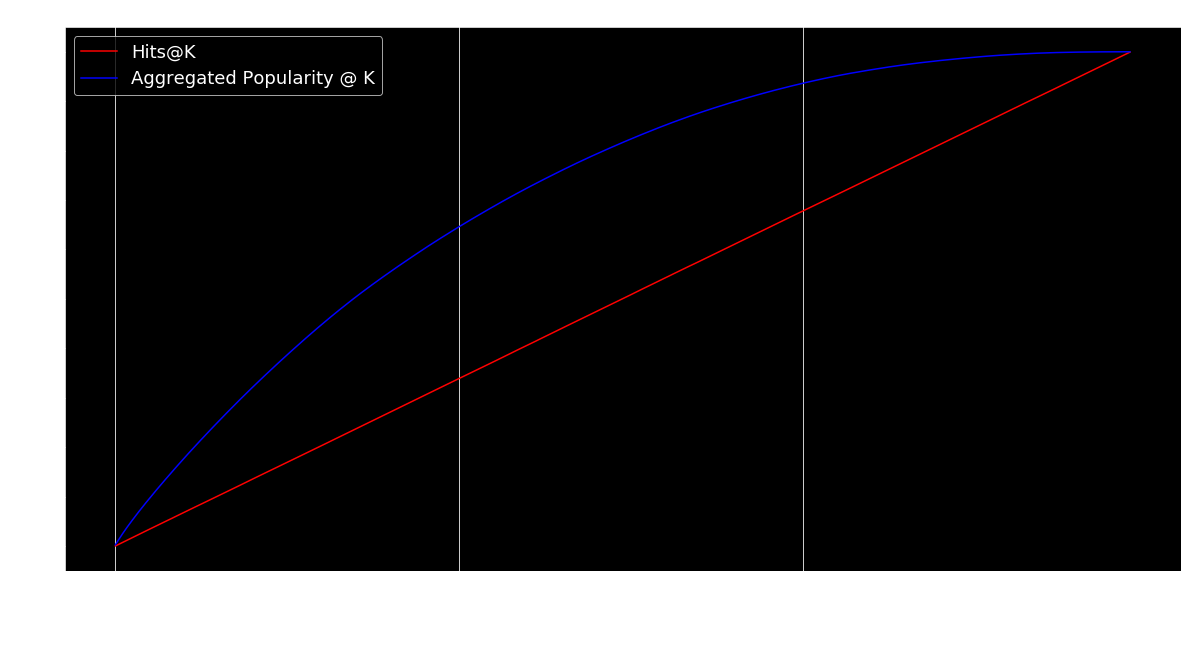

In [43]:
scores = []
for k in tqdm.tqdm_notebook(range(max_k)):
    scores.append(get_hits_at_k(ranks, k))

plt.figure(figsize=(20,10))
plt.plot(scores, c='r', label='Hits@K')
plt.plot(pop_sum, c='b', label='Aggregated Popularity @ K')
plt.xticks(np.arange(0,max_k+1, 500), [str(i) for i in np.arange(0,max_k+1, 500)], rotation='vertical', fontsize=18)
plt.yticks(np.arange(0,1.01, 0.1), [str("%0.1f" % i) for i in np.arange(0,1.01, 0.1)],  fontsize=18)
plt.ylabel('Hits @ K', fontsize=18)
plt.xlabel('Varying K (# of recommended Drugs)', fontsize=18)
plt.title('Varing Hits @ K for Distance Model', fontsize=18)
plt.legend(fontsize=18)
plt.grid(axis='x')

## Get ranks over all the possible pairs (distance model)

In [ ]:
def get_total_ranks(distances_matrix, test_pairs):
    """
    Returns the total ranks of the wanted items given a matrix of distances between all
    possible items
    Input:
        - distances_matrix:np.array,
        matrix of size NxN where each row contains the distances to the rest items
        - test_pairs:list,
        iterable for the test items. in this version it is a list of item-pairs. Each
        pair is separated by an underscore _. e.g. ['0_5', '7_8'] contains two test
        pairs 0-5 and 7-8.
    Output:
        - ranks: list,
        iterable denoting the rank that the wanted pair was found in. The minimum rank
        of an test item is 1 and the max is N^2 where N = len(distances_matrix)
    """
    from scipy.stats import rankdata
    ranks_matrix = rankdata(distances_matrix).reshape(distances_matrix.shape)
    ranks = []
    for item_joined_string in tqdm.tqdm_notebook(test_pairs):
        item = item_joined_string.split('_')
        try:
            i, j = int(item[0]), int(item[1])
            #i, j = list_of_emb_names.index(item[0]), list_of_emb_names.index(item[2])
            #print("For pair %s (%d) -- %s (%d)" % (item[0], i , item[2], j))
            #print("Neigbors of %d (with distances:" %i)
            #print(I[i,:])
            #print(D[i,:])
            try:
                ranks.append(ranks_matrix[i, j])
            except:
                print("Should not be here!")
                continue
        except:
            print("Should not be here!")
            continue
    return ranks


In [49]:
print(ranks_matrix.diagonal())
print(total_scores)

[81. 80. 17. 18. 83. 15. 57. 43. 35.  9.]
[81.0, 80.0, 17.0, 18.0, 83.0, 15.0, 57.0, 43.0, 35.0, 9.0]


In [70]:
tries = 100
x_test_pairs2 = [i for i in range(10)]
x_test_pairs2 = ['%d_%d' % (i, i) for i in x_test_pairs2]
avg = []
avg_hits = []
for try_ in range(tries):
    distances2 = np.random.random_sample((10,10))
    total_scores = get_total_ranks(distances2, x_test_pairs2)
    avg.append(np.mean(total_scores))
    avg_hits.append(get_hits_at_k(total_scores,10))
print(np.mean(avg))
print(np.mean(avg_hits))



51.047999999999995
0.10999999999999999


In [140]:
I.shape[0]**2/10

1353504.1

In [84]:
# Distances model

In [137]:
distances2 = np.copy(distances) #* (np.ones_like(adj_all) - np.clip(adj_train + np.eye(len(adj_all)), 0, 1))
np.fill_diagonal(distances2, np.max(distances2)+1)
#distances2[distances2==0] = np.max(distances2) + 1
total_scores = get_total_ranks(distances2, x_test_pairs)
print("Mean Rank for the test edges: %0.0f\nMean Rank of all edges: %0.0f\nDifference ratio of the 2 means: %0.4f" % (np.mean(total_scores), I.shape[0]**2/2, (I.shape[0]**2/2-np.mean(total_scores))/(I.shape[0]**2/2)))
print("Hits@10: %f %%" % (get_hits_at_k(total_scores, 10)))
print("Hits@ 10%%: %.4f %%" % (get_hits_at_k(total_scores, I.shape[0]**2/10)))


Mean Rank for the test edges: 5576975
Mean Rank of all edges: 6767520
Difference ratio of the 2 means: 0.1759
Hits@10: 0.000004 %
Hits@ 10%: 0.1568 %


In [138]:
# RANDOM MODEL
distances2 = np.random.random_sample(I.shape)
total_scores = get_total_ranks(distances2, x_test_pairs)
print("Mean Rank for the test edges: %0.0f\nMean Rank of all edges: %0.0f\nDifference ratio of the 2 means: %0.4f" % (np.mean(total_scores), I.shape[0]**2/2, (I.shape[0]**2/2-np.mean(total_scores))/(I.shape[0]**2/2)))
print("Hits@10: %f %%" % (get_hits_at_k(total_scores, 10)))
print("Hits@ 10%%: %.4f %%" % (get_hits_at_k(total_scores, I.shape[0]**2/10)))


Mean Rank for the test edges: 6769236
Mean Rank of all edges: 6767520
Difference ratio of the 2 means: -0.0003
Hits@10: 0.000000 %
Hits@ 10%: 0.0999 %


In [139]:
# POPULARITY MODEL
pop_ = np.sum(adj_all, axis=0)
D_pop = np.tile(rankdata(1/(pop_+0.0001)), (X_all.shape[0], 1))
distances2 = D_pop
total_scores = get_total_ranks(distances2, x_test_pairs)
print("Mean Rank for the test edges: %0.0f\nMean Rank of all edges: %0.0f\nDifference ratio of the 2 means: %0.4f" % (np.mean(total_scores), I.shape[0]**2/2, (I.shape[0]**2/2-np.mean(total_scores))/(I.shape[0]**2/2)))
print("Hits@10: %f %%" % (get_hits_at_k(total_scores, 10)))
print("Hits@ 10%%: %.4f %%" % (get_hits_at_k(total_scores, I.shape[0]**2/10)))


Mean Rank for the test edges: 3156380
Mean Rank of all edges: 6767520
Difference ratio of the 2 means: 0.5336
Hits@10: 0.000000 %
Hits@ 10%: 0.3282 %


In [59]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from scipy.stats import rankdata
distances2 = distances * (np.ones_like(adj_all) - np.clip(adj_train + np.eye(len(adj_all)), 0, 1))
distances2[distances2==0] = np.max(distances2) + 1
#probas = MinMaxScaler().fit_transform(distances2.reshape(-1,1)).ravel()
# RANDOM MODEL
distances2 = np.random.random_sample(I.shape)

ranks_matrix = rankdata(distances2).reshape(distances2.shape)
assert np.argmin(ranks_matrix) == np.argmin(distances2)

total_scores = []
for item_joined_string in tqdm.tqdm_notebook(x_test_pairs):
    item = item_joined_string.split('_')
    try:
        i, j = int(item[0]), int(item[1])
        #i, j = list_of_emb_names.index(item[0]), list_of_emb_names.index(item[2])
        #print("For pair %s (%d) -- %s (%d)" % (item[0], i , item[2], j))
        #print("Neigbors of %d (with distances:" %i)
        #print(I[i,:])
        #print(D[i,:])
        try:
            total_scores.append(ranks_matrix[i, j])
        except:
            print("Should not be here!")
            continue
    except:
        print("Should not be here!")
        continue
print("Mean Rank for the test edges: %0.0f\nMean Rank of all edges: %0.0f\nRatio of the 2 means: %0.4f" % (np.mean(total_scores), np.mean(ranks_matrix), np.mean(total_scores)/np.mean(ranks_matrix)))


Mean Rank for the test edges: 1089257
Mean Rank of all edges: 1089288
Ratio of the 2 means: 1.0000


2180038

In [103]:
pd_indexes = pd.DataFrame(np.unravel_index(np.argsort(distances2, None), adj_all.shape))

KeyboardInterrupt: 

In [99]:
def total_hits_at_K(distances)

['1293_890',
 '616_560',
 '1043_257',
 '31_1473',
 '291_1332',
 '299_1250',
 '595_525',
 '832_1270',
 '304_176',
 '1055_912',
 '204_1167',
 '91_640',
 '299_447',
 '1125_672',
 '805_640',
 '1295_191',
 '1084_121',
 '470_1405',
 '303_254',
 '820_100',
 '1427_1439',
 '620_1395',
 '507_1047',
 '940_880',
 '1035_906',
 '1130_379',
 '150_1250',
 '215_82',
 '77_400',
 '159_750',
 '1104_1320',
 '710_1267',
 '512_746',
 '1409_910',
 '207_767',
 '426_752',
 '1389_1239',
 '539_1472',
 '954_688',
 '319_1350',
 '74_1319',
 '913_85',
 '1354_900',
 '1116_829',
 '24_82',
 '46_1248',
 '807_285',
 '179_766',
 '819_995',
 '567_840',
 '51_686',
 '940_254',
 '508_1472',
 '1426_1155',
 '511_733',
 '1453_1045',
 '1167_778',
 '337_1329',
 '1275_918',
 '382_1332',
 '626_1032',
 '761_316',
 '504_533',
 '1023_1166',
 '913_865',
 '932_120',
 '587_1158',
 '1316_1232',
 '901_416',
 '1292_1026',
 '1406_356',
 '1312_338',
 '712_363',
 '1061_530',
 '52_830',
 '1135_1368',
 '1135_1431',
 '1278_327',
 '23_1291',
 '51_10

In [91]:
np.sort(distances2.ravel())

array([1.02071762e-02, 1.41887665e-02, 2.35528946e-02, ...,
       5.97848625e+01, 5.97848625e+01, 5.97848625e+01])

In [94]:
np.argsort(distances2, None)

array([1128432, 2030878, 1823074, ..., 1232278, 1232352, 2178575])

In [98]:
ranks_matrix[0,-1]

1156910.0

In [93]:
np.where(np.isclose(distances2,1.02071762e-0))

(array([], dtype=int64), array([], dtype=int64))

In [90]:
print(np.min(distances2))

0.010207176208496094


In [96]:
distances2.ravel()[1128432]

0.010207176208496094